Stock Market Prediction using News Headlines 

Data Source: https://www.kaggle.com/competitions/stock-market-prediction-and-sentimental-analysis/overview

Keras Sequential Neural Network



In [ ]:
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

Preprocessing of the News Headlines

In [ ]:
# Train Data
train = pd.read_csv("../data/Combined_News_DJIA(train).csv")
nltk.download("stopwords")
stop_words = set(
    [
        s.replace("'", "")
        for s in stopwords.words("english")
        if s not in ["not", "up", "down"]
    ]
)

# Combine all Headlines into a single String
topic_columns = train.iloc[:, -25:]
train["topics"] = topic_columns.astype(str).apply(" ".join, axis=1)
train = train.drop(columns=topic_columns)


def clean_text(raw_string):
    # Clean off any non Charecters or Number and Stopwords
    raw_string = re.sub(r"^b+\"", "", raw_string)
    raw_string = re.sub(r"^b+\'", "", raw_string)
    raw_string = re.sub(r"[^a-zA-Z1-9\s]", "", raw_string)
    raw_string = raw_string.lower()
    words = raw_string.split()
    filtered_words = [word for word in words if word not in stop_words]
    cleaned_string = " ".join(filtered_words)
    return cleaned_string

train["topics"] = train["topics"].apply(clean_text)

In [626]:
text_feature = train["topics"]
label = train["Label"]
# Split for Train and Evaluate
text_train, text_val, label_train, label_val = train_test_split(
    text_feature, label, test_size=0.2, random_state=42  
)
# Ensure correct shape of labels
label_train = tf.convert_to_tensor(label_train, dtype=tf.int64)  
label_val = tf.convert_to_tensor(label_val, dtype=tf.int64)
label_train = tf.reshape(label_train, [-1])  
label_val = tf.reshape(label_val, [-1])  

# Create Tensor Data Set
train_ds = tf.data.Dataset.from_tensor_slices(
    (tf.convert_to_tensor(text_train), tf.convert_to_tensor(label_train))
)
validate_ds = tf.data.Dataset.from_tensor_slices((text_val, label_val))

In [ ]:
# Test Data
test = pd.read_csv("../data/Test_Combined_News.csv")
topic_columns = test.iloc[:, -25:]
test["topics"] = topic_columns.astype(str).apply(" ".join, axis=1)
test = test.drop(columns=topic_columns)
test["topics"] = test["topics"].apply(clean_text)
test_text_feature = test["topics"]
test_label = test["Label"]
test_ds = tf.data.Dataset.from_tensor_slices((test_text_feature, test_label))

In [629]:
# Limit Vocabulary Size and Sequence Length
max_features = 20000
sequence_length = 500


vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    # ngrams = (1,2),
    output_mode="multi_hot",  # Possible Outputs: int, multi_hot, count, tf_idf
    pad_to_max_tokens=True,  # Only for multi_hot, count, tf_idf
    # output_sequence_length=sequence_length,
)

train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

2024-12-03 09:06:50.765239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [631]:
print("1287 ---> ", vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ", vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))

1287 --->  warming
 313 --->  ship
Vocabulary size: 20000


In [630]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    label = tf.expand_dims(label, -1)
    return vectorize_layer(text), label

In [632]:
train_ds_vec = train_ds.map(vectorize_text)
val_ds_vec = validate_ds.map(vectorize_text)
test_ds = test_ds.map(vectorize_text)

Prefetching overlaps the preprocessing and model execution of a training step. 

In [633]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_vec = train_ds_vec.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_vec = val_ds_vec.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Ensure correct Shape
for x, y in train_ds_vec.take(1):  
    print(f"Text shape: {x.shape}")
    print(f"Label shape: {y.shape}")

Text shape: (1, 20000)
Label shape: (1,)


2024-12-03 09:06:51.650890: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-12-03 09:06:51.652715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

In [635]:
embedding_dim = 16
model = tf.keras.Sequential(
    [
        layers.Embedding(max_features, embedding_dim), # Core Layer
        layers.Dropout(0.5),  #
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.5),
        layers.Dense(
            1,
            activation="sigmoid",  # Aktivation Funktion
            # Regulizers used to avoide over-fitting
            kernel_regularizer=tf.keras.regularizers.L2(
                0.01  # Regularizer to apply a penalty on the layer's kernel
            ),
            activity_regularizer=tf.keras.regularizers.L2(
                0.01  # Regularizer to apply a penalty on the layer's bias
            ),
        ),
    ]
)

In [ ]:
model.compile(
    loss=losses.BinaryCrossentropy(),  # Computes the cross-entropy loss between true labels and predicted labels.
    optimizer="adam",  # stochastic gradient descent method
    metrics=[
        tf.metrics.BinaryAccuracy(threshold=0.5)
    ],  # Calculates how often predictions match binary labels.
)

In [ ]:
epochs = 20
# Early Stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,  # Stop after 5 epochs of no improvement
    restore_best_weights=True,
)
# Fit the Model
history = model.fit(
    train_ds_vec, validation_data=val_ds_vec, epochs=epochs, callbacks=[early_stopping]
)

Epoch 1/20
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - binary_accuracy: 0.4823 - loss: 0.7734 - val_binary_accuracy: 0.4296 - val_loss: 0.7256
Epoch 2/20
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - binary_accuracy: 0.4904 - loss: 0.7284 - val_binary_accuracy: 0.4296 - val_loss: 0.7289
Epoch 3/20
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - binary_accuracy: 0.5027 - loss: 0.7061 - val_binary_accuracy: 0.4296 - val_loss: 0.7012
Epoch 4/20
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - binary_accuracy: 0.5344 - loss: 0.6965 - val_binary_accuracy: 0.4296 - val_loss: 0.6996
Epoch 5/20
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - binary_accuracy: 0.5191 - loss: 0.6955 - val_binary_accuracy: 0.4296 - val_loss: 0.6961
Epoch 6/20
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - binary_accuracy: 0.5359 - loss: 0.6955 - val_binary_accuracy: 0.4296 - val_loss: 0.7116
Epoch 7/20
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - binary_accuracy: 0.5439 - loss: 0.6949 - val_binary_accuracy: 0.4296 - val_l

In [638]:
model.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_33 (Embedding)        │ (None, 20000, 16)      │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 20000, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_33     │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 960,053 (3.66 MB)

 Trainable params: 320,017 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 640,036 (2.44 MB)

In [639]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.5200 - loss: 0.6950     
Loss:  0.6923416256904602
Accuracy:  0.5555555820465088


In [640]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

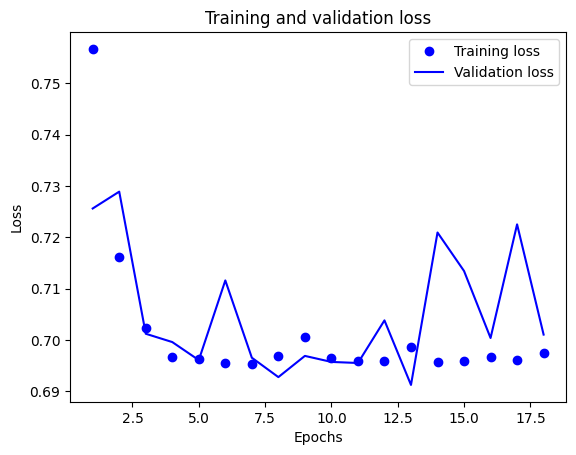

In [ ]:
acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

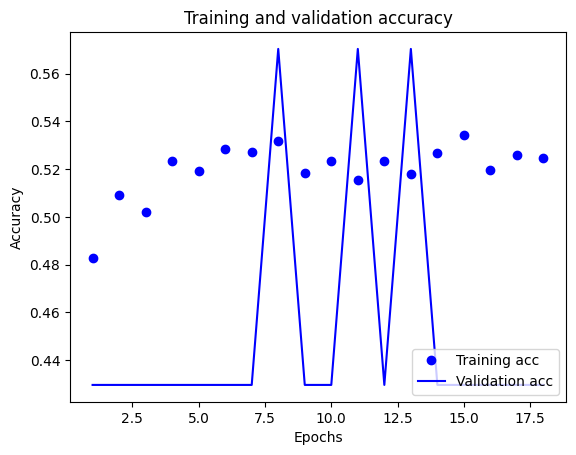

In [642]:
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.show()

In [648]:
predictions = model.predict(test_ds)
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
mse = np.mean((predictions - true_labels) ** 2)
rmse = np.sqrt(mse)

print("Root Mean Square Error (RMSE):", round(rmse,3))

  1/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Root Mean Square Error (RMSE): 0.498


2024-12-03 09:19:02.403981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
